In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import matthews_corrcoef
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier
from nltk.tokenize import word_tokenize
import numpy as np
!pip install gensim
from gensim.models import Word2Vec

## Load Dataset

In [3]:
df = pd.read_csv("lemmatized_bt_augment_train.csv")
df_test = pd.read_csv("lemmatized_original_test.csv")
print(len(df))
print(len(df_test))

8162
1341


In [4]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df_test.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
X_train = df['lemmatized and stopwords_removed']
y_train = df['sentiment']
X_test = df_test['lemmatized and stopwords_removed']
y_test = df_test['sentiment']

## Generating n-grams

In [6]:
# TfidfVectorizer (Unigram)  
corpus = X_train

vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), token_pattern=u"(?u)\\b\\w+\\b", min_df=10)

train_counts_unigram = vectorizer.fit_transform(corpus)
test_counts_unigram = vectorizer.transform(X_test)

# initialize vectorized text dataframe
df_vectorized_text_unigrams_train = pd.DataFrame(data=train_counts_unigram.toarray(), columns=vectorizer.get_feature_names())
df_vectorized_text_unigrams_test = pd.DataFrame(data=test_counts_unigram.toarray(), columns=vectorizer.get_feature_names())

################################################################

# TfidfVectorizer (Unigram & Bigram)  
corpus = X_train

vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), token_pattern=u"(?u)\\b\\w+\\b", min_df=10)

train_counts_unigram_and_bigram = vectorizer.fit_transform(corpus)
test_counts_unigram_and_bigram = vectorizer.transform(X_test)

# initialize vectorized text dataframe
df_vectorized_text_unigrams_and_bigrams_train = pd.DataFrame(data=train_counts_unigram_and_bigram.toarray(), columns=vectorizer.get_feature_names())
df_vectorized_text_unigrams_and_bigrams_test = pd.DataFrame(data=test_counts_unigram_and_bigram.toarray(), columns=vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Baseline (Unigrams) Results

## Training without Chi Square Feature Selection

In [7]:
X_train = df_vectorized_text_unigrams_train
X_test = df_vectorized_text_unigrams_test

clf = AdaBoostClassifier(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 58.11%
Test Accuracy: 65.32%
Test F1 Score: 63.83%
Mean Cross Val Accuracy: 54.96%
Mean Cross Val F1 Score: 52.83%
Testing Matthew's coefficient: 0.305


## Training with Chi Square Feature Selection

In [8]:
# 0 is chi2 score, 1 is p-value
X_train = df_vectorized_text_unigrams_train
X_test = df_vectorized_text_unigrams_test

chi2_values = chi2(X_train.values, y_train)
chi2_df = pd.DataFrame(data=chi2_values, columns=X_train.columns)
chi2_df_sorted = chi2_df.sort_values(by=0, axis = 1, ascending = False)
chi2_df_sorted

,cool,wait,want,awesome,problem,trust,amazing,scare,love,fbi,wow,concern,excited,pretty,job,weapon,worry,need,blame,point,people,wish,lazy,uber,surveillance,ugly,crash,idea,forward,wrong,flaw,wo,major,fear,shit,destroy,wtf,think,vehicle,toyota,...,merge,ok,continue,kid,focus,entire,americans,microsoft,fact,parking,sprawl,game,explain,highway,seat,tonight,engineering,nearly,hear,fly,social,term,d,little,mark,child,machine,friendly,push,article,pay,minute,ground,miss,wire,student,bike,early,enter,steve
0,1.094770e+02,7.493332e+01,5.675188e+01,4.491590e+01,4.273535e+01,4.195628e+01,3.889217e+01,3.830791e+01,3.443056e+01,3.242461e+01,2.941383e+01,2.900690e+01,27.301260,26.732276,26.617342,26.579892,26.181888,26.009676,25.586880,25.507748,24.529255,24.044088,24.023765,23.730097,23.702367,22.735597,22.644225,22.612705,21.590522,21.398124,21.252760,20.948805,20.923769,20.521494,20.181370,19.731164,18.717860,18.604187,18.551743,18.353861,...,0.256603,0.253415,0.216901,0.216353,0.191794,0.186848,0.178231,0.176625,0.173070,0.152999,0.151984,0.151526,0.149458,0.144330,0.141258,0.135170,0.130368,0.121213,0.116984,0.115450,0.111782,0.111452,0.106467,0.101715,0.090501,0.084602,0.078559,0.076051,0.067443,0.064979,0.060477,0.054338,0.050844,0.050158,0.027308,0.022072,0.007958,0.003961,0.001943,0.000051
1,1.687975e-24,5.351016e-17,4.747718e-13,1.764556e-10,5.249715e-10,7.750152e-10,3.586513e-09,4.803331e-09,3.338101e-08,9.100940e-08,4.100795e-07,5.026101e-07,0.000001,0.000002,0.000002,0.000002,0.000002,0.000002,0.000003,0.000003,0.000005,0.000006,0.000006,0.000007,0.000007,0.000012,0.000012,0.000012,0.000020,0.000023,0.000024,0.000028,0.000029,0.000035,0.000041,0.000052,0.000086,0.000091,0.000094,0.000103,...,0.879588,0.880991,0.897223,0.897469,0.908558,0.910807,0.914740,0.915475,0.917103,0.926353,0.926824,0.927036,0.927995,0.930378,0.931807,0.934648,0.936895,0.941193,0.943186,0.943909,0.945642,0.945798,0.948159,0.950414,0.955758,0.958581,0.961482,0.962689,0.966841,0.968032,0.970214,0.973197,0.974898,0.975233,0.986439,0.989025,0.996029,0.998021,0.999029,0.999974


## Finding the optimal number of features to use based on cross validation F1-score

In [9]:
f1_results_unigram_chi_square = {}
for n in range(1, 837, 5):
    chi2_columns_unigrams = chi2_df_sorted.columns[:n]
    X_train_df = df_vectorized_text_unigrams_train[chi2_columns_unigrams]

    #train MLR
    clf = AdaBoostClassifier(random_state=0)

    #Cross validation, cv=5
    f1 = cross_val_score(clf, X_train_df, y_train, scoring='f1_weighted', cv=5)
    
    #Storing mean cross validation F1-scores in a dictionary
    f1_results_unigram_chi_square[n] = f1.mean() 

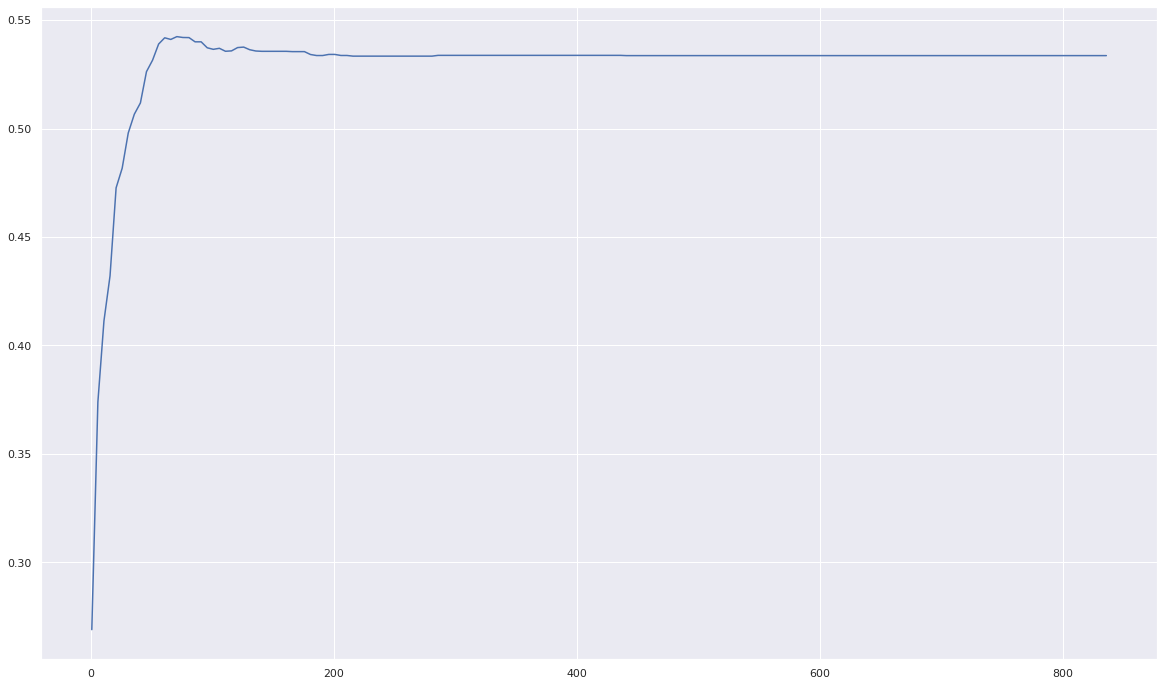

In [10]:
sns.set(rc={'figure.figsize':(20,12)})
sns.lineplot(data=f1_results_unigram_chi_square)

In [11]:
# Getting the optimal number of features which will result in best mean cross validation F1-score from the dictionary

best_no_of_features= max(f1_results_unigram_chi_square, key=f1_results_unigram_chi_square.get)
best_no_of_features

71

In [12]:
# Extracting the optimal number of features into a dataframe for training

chi2_columns = chi2_df_sorted.columns[:best_no_of_features]
X_train_vectorized_unigrams_chi_square = df_vectorized_text_unigrams_train[chi2_columns]
X_test_vectorized_unigrams_chi_square = df_vectorized_text_unigrams_test[chi2_columns]

In [13]:
X_train = X_train_vectorized_unigrams_chi_square
X_test = X_test_vectorized_unigrams_chi_square

clf = AdaBoostClassifier(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 57.85%
Test Accuracy: 66.37%
Test F1 Score: 64.41%
Mean Cross Val Accuracy: 56.30%
Mean Cross Val F1 Score: 54.11%
Testing Matthew's coefficient: 0.32


## Unigrams + Bigrams Results

## Training without Chi Square Feature Selection

In [14]:
X_train = df_vectorized_text_unigrams_and_bigrams_train
X_test = df_vectorized_text_unigrams_and_bigrams_test

clf = AdaBoostClassifier(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 57.87%
Test Accuracy: 66.07%
Test F1 Score: 64.40%
Mean Cross Val Accuracy: 55.23%
Mean Cross Val F1 Score: 53.07%
Testing Matthew's coefficient: 0.317


## Training with Chi Square Feature Selection

In [15]:
# 0 is chi2 score, 1 is p-value
X_train = df_vectorized_text_unigrams_and_bigrams_train
X_test = df_vectorized_text_unigrams_and_bigrams_test

chi2_values = chi2(X_train.values, y_train)
chi2_df = pd.DataFrame(data=chi2_values, columns=X_train.columns)
chi2_df_sorted = chi2_df.sort_values(by=0, axis = 1, ascending = False)
chi2_df_sorted

,cool,wait,problem,want,awesome,trust,amazing,scare,wait self,love,fbi,concern,worry,excited,wow,want self,weapon,point,surveillance,lazy,job,people,blame,want driverless,car cool,ugly,pretty,idea,crash,fear,flaw,car use,uber,major,wo,shit,pretty cool,vehicle,google car,wish,...,explain,legal california,mark,ground,promise self,car lol,today google,parking,child,google develop,d,google glass,hear,car end,term,talk google,buy driverless,article,machine,driverless taxi,car allow,google driver,car city,push,highway,road self,minute,car norm,little,friendly,wire,car actually,bike,google plan,feel lucky,enter,pay,early,student,steve
0,8.708846e+01,5.723568e+01,3.701021e+01,3.670220e+01,3.569579e+01,3.466529e+01,3.300328e+01,3.240834e+01,3.164995e+01,2.956964e+01,2.801794e+01,2.786799e+01,24.336476,24.170620,23.978049,23.003197,22.805028,22.456361,22.372426,22.201492,22.107093,21.645189,21.630608,21.027808,21.017246,20.839115,20.794627,20.710451,20.335142,19.268163,19.097041,18.932971,18.901386,18.520837,18.095440,17.583385,17.517391,17.260486,17.000533,16.950869,...,0.119182,0.115981,0.112750,0.102368,0.096958,0.095482,0.092347,0.092339,0.090338,0.087489,0.083610,0.082095,0.081853,0.075003,0.072641,0.071241,0.070620,0.069708,0.066221,0.063577,0.062797,0.062008,0.058210,0.056485,0.056070,0.049084,0.045553,0.043237,0.038162,0.032454,0.028203,0.018620,0.018184,0.017357,0.016723,0.015785,0.012140,0.010780,0.005156,0.003583
1,1.227383e-19,3.727611e-13,9.190396e-09,1.072059e-08,1.773197e-08,2.968439e-08,6.814415e-08,9.175267e-08,1.340607e-07,3.793451e-07,8.241038e-07,8.882656e-07,0.000005,0.000006,0.000006,0.000010,0.000011,0.000013,0.000014,0.000015,0.000016,0.000020,0.000020,0.000027,0.000027,0.000030,0.000031,0.000032,0.000038,0.000065,0.000071,0.000077,0.000079,0.000095,0.000118,0.000152,0.000157,0.000179,0.000203,0.000209,...,0.942150,0.943659,0.945185,0.950104,0.952677,0.953381,0.954876,0.954880,0.955836,0.957198,0.959057,0.959783,0.959899,0.963193,0.964331,0.965006,0.965306,0.965746,0.967432,0.968712,0.969089,0.969472,0.971315,0.972153,0.972355,0.975757,0.977481,0.978614,0.981100,0.983904,0.985997,0.990733,0.990949,0.991359,0.991673,0.992139,0.993949,0.994625,0.997425,0.998210


## Finding the optimal number of features to use based on cross validation F1-score

In [16]:
f1_results_unigram_bigram = {}
for n in range(1, 1200, 5):
    chi2_columns_unigram_bigram = chi2_df_sorted.columns[:n]
    X_train_df = df_vectorized_text_unigrams_and_bigrams_train[chi2_columns_unigram_bigram]

    #train MLR
    clf = AdaBoostClassifier(random_state=0)

    #Cross validation, cv=5
    f1 = cross_val_score(clf, X_train_df, y_train, scoring='f1_weighted', cv=5)
    
    #Storing mean cross validation F1-scores in a dictionary
    f1_results_unigram_bigram[n] = f1.mean() 

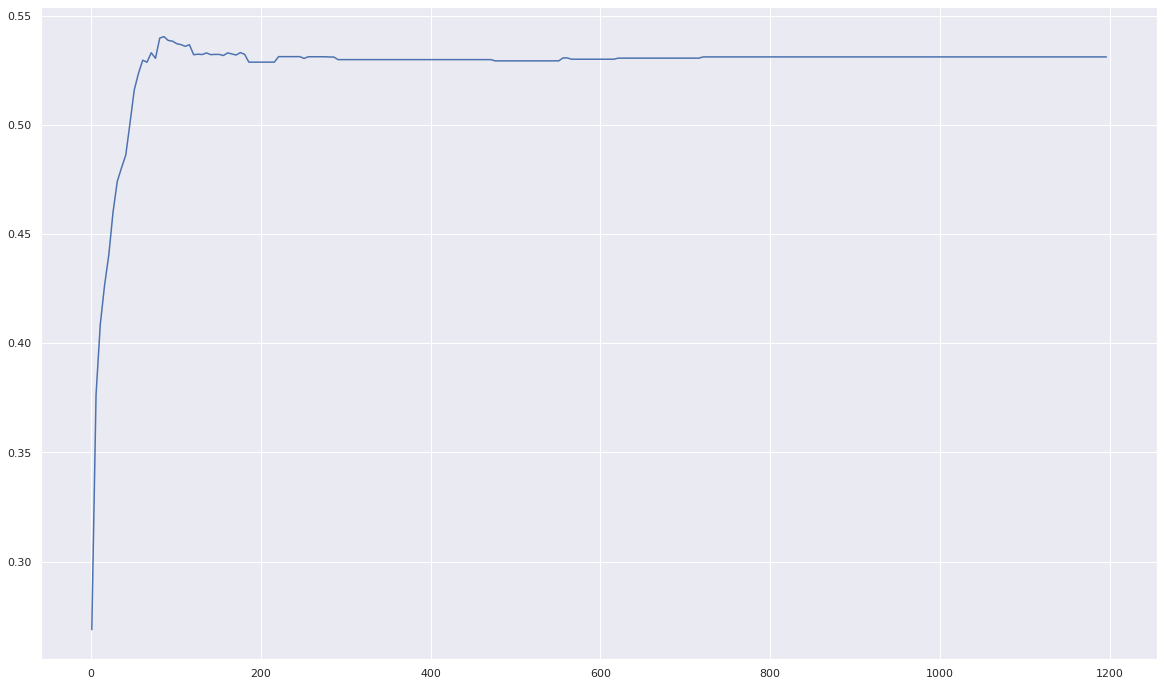

In [17]:
sns.set(rc={'figure.figsize':(20,12)})
sns.lineplot(data=f1_results_unigram_bigram)

In [18]:
# Getting the optimal number of features which will result in best mean cross validation F1-score from the dictionary

best_no_of_features= max(f1_results_unigram_bigram, key=f1_results_unigram_bigram.get)
best_no_of_features

86

In [19]:
# Extracting the optimal number of features into a dataframe for training

chi2_columns = chi2_df_sorted.columns[:best_no_of_features]
X_train_vectorized_unigram_bigram_chi_square = df_vectorized_text_unigrams_and_bigrams_train[chi2_columns]
X_test_vectorized_unigram_bigram_chi_square = df_vectorized_text_unigrams_and_bigrams_test[chi2_columns]

In [20]:
X_train = X_train_vectorized_unigram_bigram_chi_square
X_test = X_test_vectorized_unigram_bigram_chi_square

clf = AdaBoostClassifier(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 57.40%
Test Accuracy: 66.22%
Test F1 Score: 64.38%
Mean Cross Val Accuracy: 56.10%
Mean Cross Val F1 Score: 53.98%
Testing Matthew's coefficient: 0.317


## Unigrams + Bigrams + Unsupervised Topics Results

In [21]:
unsupervised_topics=[(1,
  [('autonomous', 0.12041249620867456),
   ('vehicle', 0.10737033666969972),
   ('driving', 0.05338186229905975),
   ('tech', 0.03306035790112223),
   ('auto', 0.02456778889899909),
   ('insurance', 0.02305125872004853),
   ('nissan', 0.01668183196845617),
   ('law', 0.01637852593266606),
   ('toyota', 0.014255383682135275),
   ('robotic', 0.011828935395814377),
   ('hate', 0.010615711252653927),
   ('automate', 0.010615711252653927),
   ('research', 0.010312405216863815),
   ('industry', 0.009705793145283591),
   ('impact', 0.009099181073703366),
   ('require', 0.008492569002123142),
   ('connected', 0.008492569002123142),
   ('michigan', 0.008492569002123142),
   ('completely', 0.00818926296633303),
   ('study', 0.00818926296633303),
   ('university', 0.007279344858962694),
   ('sell', 0.006976038823172581),
   ('team', 0.006976038823172581),
   ('win', 0.006672732787382469),
   ('arbor', 0.006369426751592357),
   ('ann', 0.006369426751592357),
   ('center', 0.006066120715802244),
   ('motor', 0.005762814680012132),
   ('semi', 0.005762814680012132),
   ('fake', 0.00545950864422202)]),
 (2,
  [('wait', 0.06664609688367788),
   ('ride', 0.04813329219376736),
   ('great', 0.035791422400493676),
   ('watch', 0.03363159518667078),
   ('idea', 0.032088861462511574),
   ('find', 0.01974699166923789),
   ('parking', 0.01974699166923789),
   ('lot', 0.019438444924406047),
   ('park', 0.01666152422091947),
   ('service', 0.016044430731255787),
   ('lexus', 0.015427337241592102),
   ('government', 0.01511879049676026),
   ('hand', 0.014810243751928418),
   ('roll', 0.012650416538105523),
   ('imagine', 0.01203332304844184),
   ('man', 0.01203332304844184),
   ('share', 0.01203332304844184),
   ('home', 0.010490589324282628),
   ('light', 0.010182042579450786),
   ('camera', 0.008947855600123419),
   ('pull', 0.008330762110459735),
   ('passenger', 0.008330762110459735),
   ('pick', 0.008330762110459735),
   ('blind', 0.008022215365627893),
   ('child', 0.007713668620796051),
   ('meet', 0.007405121875964209),
   ('dog', 0.007405121875964209),
   ('lead', 0.007405121875964209),
   ('shit', 0.006788028386300524),
   ('la', 0.006170934896636841)]),
 (3,
  [('google', 0.12093308778391651),
   ('time', 0.05586249232658073),
   ('nt', 0.03591160220994475),
   ('buy', 0.030079803560466543),
   ('apple', 0.024248004910988337),
   ('long', 0.022713321055862493),
   ('awesome', 0.021485573971761818),
   ('company', 0.019643953345610803),
   ('smart', 0.015346838551258441),
   ('phone', 0.015039901780233272),
   ('news', 0.014732965009208104),
   ('wo', 0.011663597298956415),
   ('nice', 0.011663597298956415),
   ('check', 0.011663597298956415),
   ('hear', 0.010128913443830571),
   ('forward', 0.010128913443830571),
   ('invest', 0.009208103130755065),
   ('sit', 0.008594229588704727),
   ('scary', 0.008594229588704727),
   ('dangerous', 0.008594229588704727),
   ('play', 0.008287292817679558),
   ('spend', 0.008287292817679558),
   ('game', 0.008287292817679558),
   ('android', 0.008287292817679558),
   ('small', 0.007059545733578883),
   ('head', 0.007059545733578883),
   ('mobile', 0.006752608962553714),
   ('app', 0.006445672191528545),
   ('age', 0.006445672191528545),
   ('campus', 0.006138735420503376)]),
 (4,
  [('google', 0.14017521902377972),
   ('problem', 0.03660826032540676),
   ('traffic', 0.0353566958698373),
   ('human', 0.03285356695869837),
   ('pass', 0.03097622027534418),
   ('good', 0.025344180225281603),
   ('speed', 0.01939924906132666),
   ('feel', 0.019086357947434292),
   ('turn', 0.0172090112640801),
   ('bring', 0.015644555694618274),
   ('solve', 0.013454317897371715),
   ('lane', 0.012828535669586983),
   ('limit', 0.011889862327909888),
   ('change', 0.011889862327909888),
   ('report', 0.00969962453066333),
   ('challenge', 0.00969962453066333),
   ('travel', 0.009073842302878598),
   ('totally', 0.008760951188986232),
   ('solution', 0.008760951188986232),
   ('miss', 0.008448060075093867),
   ('mainstream', 0.008135168961201502),
   ('wtf', 0.008135168961201502),
   ('major', 0.007509386733416771),
   ('bike', 0.0071964956195244055),
   ('concern', 0.00688360450563204),
   ('nyc', 0.006257822277847309),
   ('potential', 0.006257822277847309),
   ('waste', 0.005944931163954944),
   ('purchase', 0.005632040050062578),
   ('apparently', 0.005632040050062578)]),
 (5,
  [('google', 0.18500154942671213),
   ('technology', 0.06259683916950728),
   ('ready', 0.03563681437867989),
   ('legal', 0.027269910133250697),
   ('map', 0.025720483421134182),
   ('spot', 0.023241400681747754),
   ('state', 0.019832661915091417),
   ('ford', 0.017043693833281685),
   ('morning', 0.01673380849085838),
   ('guy', 0.01580415246358847),
   ('innovation', 0.015494267121165169),
   ('money', 0.013325069724202046),
   ('pic', 0.013015184381778741),
   ('sound', 0.012395413696932134),
   ('learn', 0.010226216299969011),
   ('goog', 0.009916330957545709),
   ('perfect', 0.009296560272699102),
   ('nevada', 0.008986674930275797),
   ('florida', 0.008676789587852495),
   ('face', 0.008676789587852495),
   ('gm', 0.00836690424542919),
   ('cruise', 0.007437248218159281),
   ('decade', 0.007437248218159281),
   ('cheap', 0.006817477533312674),
   ('fuck', 0.006507592190889371),
   ('commute', 0.006197706848466067),
   ('ahead', 0.005887821506042764),
   ('trend', 0.005887821506042764),
   ('stanford', 0.005577936163619461),
   ('base', 0.005577936163619461)]),
 (6,
  [('wheel', 0.0640625),
   ('california', 0.0615625),
   ('test', 0.0525),
   ('build', 0.0396875),
   ('steering', 0.0384375),
   ('prototype', 0.0221875),
   ('audi', 0.021875),
   ('unveil', 0.0190625),
   ('break', 0.0178125),
   ('start', 0.0159375),
   ('develop', 0.015625),
   ('pedal', 0.015625),
   ('brake', 0.014375),
   ('license', 0.0125),
   ('googleplex', 0.0125),
   ('worth', 0.011875),
   ('seat', 0.011875),
   ('sign', 0.0115625),
   ('bill', 0.0109375),
   ('permit', 0.010625),
   ('testing', 0.0103125),
   ('approve', 0.0096875),
   ('ce', 0.0090625),
   ('hell', 0.0084375),
   ('dmv', 0.0084375),
   ('trillion', 0.0075),
   ('release', 0.0075),
   ('san', 0.0071875),
   ('button', 0.0065625),
   ('post', 0.0059375)]),
 (7,
  [('future', 0.1156773211567732),
   ('year', 0.049010654490106546),
   ('happen', 0.026788432267884323),
   ('tesla', 0.026484018264840183),
   ('big', 0.026484018264840183),
   ('good', 0.025266362252663623),
   ('truck', 0.02161339421613394),
   ('amazing', 0.019178082191780823),
   ('highway', 0.01796042617960426),
   ('fun', 0.015525114155251141),
   ('control', 0.014611872146118721),
   ('mt', 0.011872146118721462),
   ('reality', 0.011263318112633182),
   ('sleep', 0.0106544901065449),
   ('week', 0.010350076103500762),
   ('cyclist', 0.01004566210045662),
   ('codecon', 0.01004566210045662),
   ('inside', 0.009741248097412482),
   ('ceo', 0.008828006088280061),
   ('fully', 0.00821917808219178),
   ('datum', 0.00821917808219178),
   ('yeah', 0.007914764079147641),
   ('bmw', 0.007914764079147641),
   ('exciting', 0.007914764079147641),
   ('guess', 0.0076103500761035),
   ('bet', 0.0076103500761035),
   ('power', 0.0076103500761035),
   ('tv', 0.0073059360730593605),
   ('tech', 0.007001522070015221),
   ('model', 0.006697108066971081)]),
 (8,
  [('cool', 0.07112201103617413),
   ('uber', 0.05947271612507664),
   ('taxi', 0.040159411404046594),
   ('view', 0.026364193746167996),
   ('pretty', 0.023911710606989576),
   ('real', 0.020846106683016553),
   ('job', 0.019313304721030045),
   ('train', 0.018087063151440833),
   ('electric', 0.01624770079705702),
   ('mountain', 0.014714898835070508),
   ('business', 0.014408338442673207),
   ('fleet', 0.013795217657878603),
   ('infrastructure', 0.011342734518700184),
   ('shit', 0.010116492949110975),
   ('detroit', 0.010116492949110975),
   ('economy', 0.00950337216431637),
   ('bad', 0.009196811771919068),
   ('reduce', 0.009196811771919068),
   ('race', 0.008890251379521767),
   ('sf', 0.008890251379521767),
   ('sense', 0.008583690987124463),
   ('googlecar', 0.008583690987124463),
   ('replace', 0.00827713059472716),
   ('start', 0.00827713059472716),
   ('destroy', 0.007664009809932557),
   ('million', 0.007664009809932557),
   ('exist', 0.007357449417535254),
   ('blame', 0.00674432863274065),
   ('machine', 0.006437768240343348),
   ('fuel', 0.0061312078479460455)]),
 (9,
  [('road', 0.08997828110456096),
   ('people', 0.08098045299410488),
   ('day', 0.038163201985727584),
   ('safe', 0.029785913744958113),
   ('trust', 0.027614024201054917),
   ('stop', 0.024201054917778467),
   ('public', 0.023890784982935155),
   ('crash', 0.023270245113248527),
   ('kill', 0.018926466025442134),
   ('place', 0.017064846416382253),
   ('wrong', 0.016134036611852313),
   ('bus', 0.014582686937635743),
   ('drunk', 0.014582686937635743),
   ('hour', 0.013651877133105802),
   ('die', 0.013341607198262488),
   ('valley', 0.012721067328575862),
   ('worry', 0.012721067328575862),
   ('issue', 0.012410797393732548),
   ('reason', 0.012100527458889234),
   ('death', 0.012100527458889234),
   ('silicon', 0.011479987589202606),
   ('pay', 0.010238907849829351),
   ('damn', 0.010238907849829351),
   ('agree', 0.008687558175612783),
   ('uk', 0.008067018305926156),
   ('hard', 0.007446478436239528),
   ('happy', 0.007136208501396215),
   ('begin', 0.007136208501396215),
   ('kid', 0.006515668631709587),
   ('decide', 0.006515668631709587)]),
 (10,
  [('google', 0.17111459968602827),
   ('thing', 0.05588697017268446),
   ('robot', 0.04144427001569859),
   ('hope', 0.02794348508634223),
   ('interesting', 0.02260596546310832),
   ('run', 0.021036106750392466),
   ('fast', 0.020094191522762952),
   ('dream', 0.015384615384615385),
   ('project', 0.015070643642072213),
   ('step', 0.012872841444270016),
   ('omg', 0.012558869701726845),
   ('internet', 0.01130298273155416),
   ('cute', 0.01098901098901099),
   ('program', 0.01098901098901099),
   ('past', 0.010675039246467817),
   ('true', 0.010361067503924647),
   ('drivingcar', 0.010047095761381476),
   ('finally', 0.010047095761381476),
   ('follow', 0.009733124018838305),
   ('pedestrian', 0.008791208791208791),
   ('area', 0.00816326530612245),
   ('thought', 0.00816326530612245),
   ('expect', 0.0075353218210361065),
   ('automaker', 0.007221350078492936),
   ('fb', 0.006593406593406593),
   ('search', 0.006593406593406593),
   ('vision', 0.006279434850863423),
   ('tonight', 0.005965463108320251),
   ('dear', 0.005337519623233909),
   ('massive', 0.005023547880690738)]),
 (11,
  [('google', 0.19200484554815264),
   ('street', 0.06359781950333132),
   ('city', 0.051181102362204724),
   ('accident', 0.03876438522107813),
   ('life', 0.03179890975166566),
   ('hit', 0.025439127801332527),
   ('mile', 0.020290732889158086),
   ('wow', 0.018473652331920047),
   ('save', 0.017867958812840704),
   ('lol', 0.01665657177468201),
   ('plan', 0.015445184736523319),
   ('free', 0.014536644457904301),
   ('googles', 0.012113870381586917),
   ('crazy', 0.01150817686250757),
   ('complete', 0.009993943064809207),
   ('house', 0.008782556026650516),
   ('master', 0.008782556026650516),
   ('open', 0.008479709267110842),
   ('person', 0.00817686250757117),
   ('deal', 0.007571168988491823),
   ('volvo', 0.006965475469412477),
   ('fall', 0.005754088431253785),
   ('number', 0.005754088431253785),
   ('concept', 0.005754088431253785),
   ('navigate', 0.005754088431253785),
   ('involve', 0.005451241671714113),
   ('fill', 0.00514839491217444),
   ('important', 0.00514839491217444),
   ('trip', 0.004845548152634767),
   ('announce', 0.004845548152634767)]),
 (12,
  [('work', 0.06364513018322084),
   ('today', 0.05914496946319511),
   ('love', 0.037608486017357765),
   ('video', 0.027965284474445518),
   ('talk', 0.026679524268723883),
   ('live', 0.0196078431372549),
   ('read', 0.01832208293153327),
   ('end', 0.016072002571520413),
   ('road', 0.014786242365798778),
   ('market', 0.014143362262937963),
   ('bad', 0.013821922211507553),
   ('article', 0.013500482160077145),
   ('home', 0.013500482160077145),
   ('safety', 0.01285760205721633),
   ('excited', 0.01285760205721633),
   ('system', 0.01253616200578592),
   ('ticket', 0.011893281902925105),
   ('space', 0.011571841851494697),
   ('office', 0.011571841851494697),
   ('transit', 0.011250401800064288),
   ('launch', 0.011250401800064288),
   ('story', 0.010607521697203472),
   ('change', 0.009964641594342655),
   ('cost', 0.009643201542912247),
   ('mass', 0.009643201542912247),
   ('picture', 0.00900032144005143),
   ('tweet', 0.008678881388621022),
   ('super', 0.008036001285760206),
   ('yesterday', 0.007714561234329798),
   ('friend', 0.007071681131468981)]),
 (13,
  [('google', 0.16856287425149702),
   ('world', 0.041916167664670656),
   ('glass', 0.027544910179640718),
   ('drone', 0.026347305389221556),
   ('design', 0.023952095808383235),
   ('transportation', 0.018263473053892216),
   ('fly', 0.016766467065868262),
   ('point', 0.01526946107784431),
   ('legalize', 0.01347305389221557),
   ('fbi', 0.012874251497005988),
   ('question', 0.012574850299401197),
   ('transport', 0.012275449101796407),
   ('invent', 0.012275449101796407),
   ('close', 0.011976047904191617),
   ('hurry', 0.011377245508982036),
   ('hey', 0.011077844311377245),
   ('computer', 0.010778443113772455),
   ('high', 0.010479041916167664),
   ('push', 0.009281437125748504),
   ('write', 0.008682634730538923),
   ('deliver', 0.008682634730538923),
   ('fear', 0.008083832335329342),
   ('weapon', 0.008083832335329342),
   ('warn', 0.0074850299401197605),
   ('easy', 0.0074850299401197605),
   ('delivery', 0.00718562874251497),
   ('stuff', 0.0068862275449101795),
   ('rule', 0.0068862275449101795),
   ('bomb', 0.006586826347305389),
   ('ad', 0.005988023952095809)])]

df_train_unsupervised_unigram_bigram=df.copy()
df_test_unsupervised_unigram_bigram=df_test.copy()

def assign_topic_score(text, topic_no):
    topic_list=unsupervised_topics[topic_no-1][1]    
    
    wordlist=text.split(' ')
    topic_score=0
    for word in wordlist:
        for word_weight in topic_list:
            if word==word_weight[0]:
                topic_score+=word_weight[1]
                
    return topic_score
    
for each_topic in unsupervised_topics:
    df_train_unsupervised_unigram_bigram['unsupervised_topic_' + str(each_topic[0])]= df_train_unsupervised_unigram_bigram.apply(lambda row: assign_topic_score(row['lemmatized and stopwords_removed'], each_topic[0]), axis=1)
    df_test_unsupervised_unigram_bigram['unsupervised_topic_' + str(each_topic[0])]= df_test_unsupervised_unigram_bigram.apply(lambda row: assign_topic_score(row['lemmatized and stopwords_removed'], each_topic[0]), axis=1)

    

## Training without Chi Square Feature Selection

## Preparing data for model training

In [22]:
# Scaling the Unsupervised topics

scaler = MinMaxScaler()
scaled_train_unsupervised_unigram_bigram = scaler.fit_transform(df_train_unsupervised_unigram_bigram.iloc[:, 3:])
scaled_test_unsupervised_unigram_bigram = scaler.transform(df_test_unsupervised_unigram_bigram.iloc[:, 3:])

# Transforming scaled topics into a dataframe

scaled_train_unsupervised_unigram_bigram_df = pd.DataFrame(scaled_train_unsupervised_unigram_bigram, columns = df_train_unsupervised_unigram_bigram.iloc[:, 3:].columns)
scaled_test_unsupervised_unigram_bigram_df = pd.DataFrame(scaled_test_unsupervised_unigram_bigram, columns = df_test_unsupervised_unigram_bigram.iloc[:, 3:].columns)

# Combining Unigrams + Bigrams + Unsupervised topics into one dataframe

train_unsupervised_unigram_bigram = pd.concat([scaled_train_unsupervised_unigram_bigram_df, df_vectorized_text_unigrams_and_bigrams_train], axis=1)
test_unsupervised_unigram_bigram = pd.concat([scaled_test_unsupervised_unigram_bigram_df, df_vectorized_text_unigrams_and_bigrams_test], axis=1)

In [23]:
X_train = train_unsupervised_unigram_bigram
X_test = test_unsupervised_unigram_bigram

clf = AdaBoostClassifier(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 57.57%
Test Accuracy: 64.65%
Test F1 Score: 63.86%
Mean Cross Val Accuracy: 54.80%
Mean Cross Val F1 Score: 53.08%
Testing Matthew's coefficient: 0.306


## Training with Chi Square Feature Selection

## Preparing data for model training

In [24]:
# Scaling the Unsupervised topics

scaler = MinMaxScaler()
scaled_train_unsupervised_unigram_bigram_chi_square = scaler.fit_transform(df_train_unsupervised_unigram_bigram.iloc[:, 3:])
scaled_test_unsupervised_unigram_bigram_chi_square = scaler.transform(df_test_unsupervised_unigram_bigram.iloc[:, 3:])

# Transforming scaled topics into a dataframe

scaled_train_unsupervised_unigram_bigram_chi_square_df = pd.DataFrame(scaled_train_unsupervised_unigram_bigram_chi_square, columns = df_train_unsupervised_unigram_bigram.iloc[:, 3:].columns)
scaled_test_unsupervised_unigram_bigram_chi_square_df = pd.DataFrame(scaled_test_unsupervised_unigram_bigram_chi_square, columns = df_test_unsupervised_unigram_bigram.iloc[:, 3:].columns)

# Combining Unigrams + Bigrams + Unsupervised topics into one dataframe

train_unsupervised_unigram_bigram_chi_square_df = pd.concat([scaled_train_unsupervised_unigram_bigram_chi_square_df, df_vectorized_text_unigrams_and_bigrams_train], axis=1)
test_unsupervised_unigram_bigram_chi_square_df = pd.concat([scaled_test_unsupervised_unigram_bigram_chi_square_df, df_vectorized_text_unigrams_and_bigrams_test], axis=1)

In [25]:
# 0 is chi2 score, 1 is p-value
X_train = train_unsupervised_unigram_bigram_chi_square_df
X_test = test_unsupervised_unigram_bigram_chi_square_df

chi2_values = chi2(X_train.values, y_train)
chi2_df = pd.DataFrame(data=chi2_values, columns=X_train.columns)
chi2_df_sorted = chi2_df.sort_values(by=0, axis = 1, ascending = False)
chi2_df_sorted

,cool,wait,problem,want,awesome,trust,unsupervised_topic_2,amazing,scare,wait self,love,unsupervised_topic_1,fbi,concern,worry,excited,wow,unsupervised_topic_8,want self,weapon,point,surveillance,lazy,job,people,blame,want driverless,car cool,ugly,pretty,idea,crash,unsupervised_topic_9,fear,flaw,car use,unsupervised_topic_6,uber,major,wo,...,explain,legal california,mark,ground,promise self,car lol,today google,parking,child,google develop,d,google glass,hear,car end,term,talk google,buy driverless,article,machine,driverless taxi,car allow,google driver,car city,push,highway,road self,minute,car norm,little,friendly,wire,car actually,bike,google plan,feel lucky,enter,pay,early,student,steve
0,8.708846e+01,5.723568e+01,3.701021e+01,3.670220e+01,3.569579e+01,3.466529e+01,3.424176e+01,3.300328e+01,3.240834e+01,3.164995e+01,2.956964e+01,2.809826e+01,2.801794e+01,2.786799e+01,24.336476,24.170620,23.978049,23.738350,23.003197,22.805028,22.456361,22.372426,22.201492,22.107093,21.645189,21.630608,21.027808,21.017246,20.839115,20.794627,20.710451,20.335142,19.641834,19.268163,19.097041,18.932971,18.906843,18.901386,18.520837,18.095440,...,0.119182,0.115981,0.112750,0.102368,0.096958,0.095482,0.092347,0.092339,0.090338,0.087489,0.083610,0.082095,0.081853,0.075003,0.072641,0.071241,0.070620,0.069708,0.066221,0.063577,0.062797,0.062008,0.058210,0.056485,0.056070,0.049084,0.045553,0.043237,0.038162,0.032454,0.028203,0.018620,0.018184,0.017357,0.016723,0.015785,0.012140,0.010780,0.005156,0.003583
1,1.227383e-19,3.727611e-13,9.190396e-09,1.072059e-08,1.773197e-08,2.968439e-08,3.668565e-08,6.814415e-08,9.175267e-08,1.340607e-07,3.793451e-07,7.916642e-07,8.241038e-07,8.882656e-07,0.000005,0.000006,0.000006,0.000007,0.000010,0.000011,0.000013,0.000014,0.000015,0.000016,0.000020,0.000020,0.000027,0.000027,0.000030,0.000031,0.000032,0.000038,0.000054,0.000065,0.000071,0.000077,0.000078,0.000079,0.000095,0.000118,...,0.942150,0.943659,0.945185,0.950104,0.952677,0.953381,0.954876,0.954880,0.955836,0.957198,0.959057,0.959783,0.959899,0.963193,0.964331,0.965006,0.965306,0.965746,0.967432,0.968712,0.969089,0.969472,0.971315,0.972153,0.972355,0.975757,0.977481,0.978614,0.981100,0.983904,0.985997,0.990733,0.990949,0.991359,0.991673,0.992139,0.993949,0.994625,0.997425,0.998210


In [26]:
f1_results_unsupervised_unigram_bigram_chi_square = {}
for n in range(1, 1213, 5):
    chi2_columns_unsupervised_unigram_bigram = chi2_df_sorted.columns[:n]
    X_train_df = train_unsupervised_unigram_bigram_chi_square_df[chi2_columns_unsupervised_unigram_bigram]

    #train MLR
    clf = AdaBoostClassifier(random_state=0)

    #Cross validation, cv=5
    f1 = cross_val_score(clf, X_train_df, y_train, scoring='f1_weighted', cv=5)
    
    #Storing mean cross validation F1-scores in a dictionary
    f1_results_unsupervised_unigram_bigram_chi_square[n] = f1.mean() 

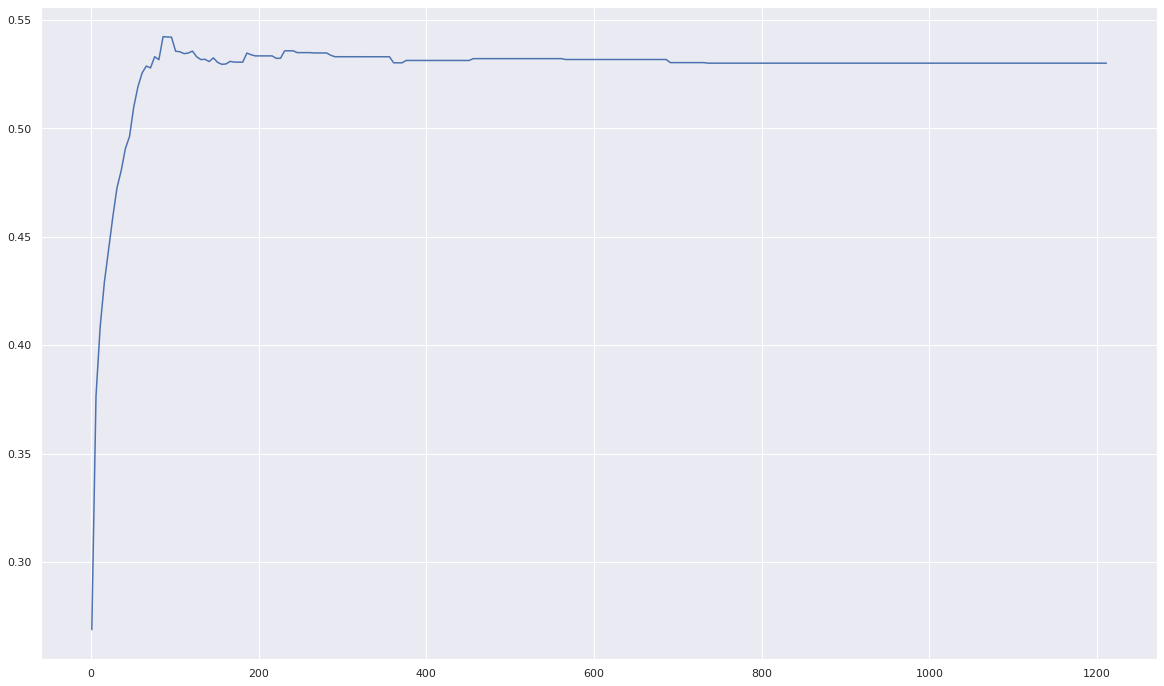

In [27]:
sns.set(rc={'figure.figsize':(20,12)})
sns.lineplot(data=f1_results_unsupervised_unigram_bigram_chi_square)

In [28]:
# Extracting the optimal number of features into a dataframe for training

chi2_columns = chi2_df_sorted.columns[:best_no_of_features]
scaled_train_unsupervised_unigram_bigram_df_chi_square = train_unsupervised_unigram_bigram_chi_square_df[chi2_columns]
scaled_test_unsupervised_unigram_bigram_df_chi_square = test_unsupervised_unigram_bigram_chi_square_df[chi2_columns]

In [29]:
X_train = scaled_train_unsupervised_unigram_bigram_df_chi_square
X_test = scaled_test_unsupervised_unigram_bigram_df_chi_square

clf = AdaBoostClassifier(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 56.84%
Test Accuracy: 64.28%
Test F1 Score: 63.30%
Mean Cross Val Accuracy: 55.37%
Mean Cross Val F1 Score: 53.70%
Testing Matthew's coefficient: 0.296


## Unigrams + Bigrams + Supervised topics Results

In [30]:
# These topics are generated manually by observing highest frequency words.

def accident(text):
    wordlist=['die', 'death', 'kill', 'hit', 'crash', 'accident', 'insurance', 'drunk', 'drink', 'safety', 'speed', 'limit']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def change(text):
    wordlist=['change', 'replace', 'become', 'happen', 'transform']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def imagination_vs_reality(text):
    wordlist= ['reality', 'dream', 'imagine', 'imagination', 'challenge']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def law(text):
    wordlist=['policy', 'law', 'legal', 'government', 'state', 'regulation', 'license', 'approve', 'allow', 'rule', 
              'public']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def time(text):
    wordlist=['future', 'today', 'next', 'year', 'past', 'world']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def technology(text):
    wordlist=['technology', 'tech', 'robot', 'drone', 'machine', 'computer', 'robotic', 'program', 'ai', 'automobile', 
              'electric', 'system', 'information', 'data', 'automate']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def innovation(text):
    wordlist=['research', 'invent', 'innovation', 'innovate', 'invention', 'breakthrough', 'idea', 'develop', 
              'create', 'prototype', 'develop', 'build']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def business(text):
    wordlist=['money', 'invest', 'market', 'ceo', 'cost', 'buy', 'business', 'company']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0


def positive_words(text):
    wordlist=['get', 'want', 'cool', 'good', 'great', 'love', 'awesome', 'wow', 'perfect', 'solve', 'solution', 
              'excite', 'fun', 'safe', 'help', 'best', 'hope', 'lead']
              
    double_words=['look forward', 'cant wait']
    
    count=0
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            count+=1
            wordlist.remove(word)
    
    for phrase in double_words:
        if phrase in text:
            count+=1
              
    return count
              
              

def bad_words(text):
    wordlist=['never', 'fuck', 'shit', 'hell', 'scary', 'wtf', 'freak', 'hate', 'wrong', 'worry', 'die', 
              'kill', 'bad', 'crazy', 'death', 'problem', 'dangerous']
    count=0
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            count+=1
            wordlist.remove(word)
    
    return count


#brands/places/transportation type/events/products
columns=['toyota', 'audi', 'tesla', 'apple', 'google', 'uber', 'ford', 'lexus', 'nissan', 'volvo', 'bmw', 'california', 
         'michigan', 'detroit', 'googleplex', 'dmv', 'ce', 'codecon', 'forbes', 
         'cnet', 'wsj', 'train', 'railway', 'cruise', 'road', 'taxi', 'truck', 'highway', 'bus', 'cab', 'bike', 'freeway',
         'googlecar', 'camera', 'ego']

double_words=['ann arbor', 'silicon valley', 'google map', 'google glass']

def get_column_value(text, word):
    wordlist=text.split(' ')
    if word in wordlist:
        return 1
    return 0

def get_double_value(text, phrase):
    if phrase in text:
        return 1
    return 0

In [31]:
df_train_supervised_unigram_bigram=df.copy()
df_test_supervised_unigram_bigram=df_test.copy()

In [32]:
for word in columns:
    df_train_supervised_unigram_bigram['topic ' + word]=df_train_supervised_unigram_bigram.apply(lambda x: get_column_value(x['lemmatized and stopwords_removed'], word), axis=1)
    df_test_supervised_unigram_bigram['topic ' + word]=df_test_supervised_unigram_bigram.apply(lambda x: get_column_value(x['lemmatized and stopwords_removed'], word), axis=1)
for phrase in double_words:
    df_train_supervised_unigram_bigram['topic ' + phrase]=df_train_supervised_unigram_bigram.apply(lambda x: get_double_value(x['lemmatized and stopwords_removed'], phrase), axis=1)
    df_test_supervised_unigram_bigram['topic ' + phrase]=df_test_supervised_unigram_bigram.apply(lambda x: get_column_value(x['lemmatized and stopwords_removed'], word), axis=1)

In [33]:
# train dataset
df_train_supervised_unigram_bigram['topic accident']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(accident)
df_train_supervised_unigram_bigram['topic change']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(change)
df_train_supervised_unigram_bigram['topic imagination_vs_reality']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(imagination_vs_reality)
df_train_supervised_unigram_bigram['topic law']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(law)
df_train_supervised_unigram_bigram['topic time']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(time)
df_train_supervised_unigram_bigram['topic technology']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(technology)
df_train_supervised_unigram_bigram['topic innovation']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(innovation)
df_train_supervised_unigram_bigram['topic business']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(business)

df_train_supervised_unigram_bigram['topic positive_words']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(positive_words)
df_train_supervised_unigram_bigram['topic bad_words']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(bad_words)
df_train_supervised_unigram_bigram['topic net positive']=df_train_supervised_unigram_bigram['topic positive_words']-df_train_supervised_unigram_bigram['topic bad_words']

# test dataset

df_test_supervised_unigram_bigram['topic accident']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(accident)
df_test_supervised_unigram_bigram['topic change']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(change)
df_test_supervised_unigram_bigram['topic imagination_vs_reality']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(imagination_vs_reality)
df_test_supervised_unigram_bigram['topic law']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(law)
df_test_supervised_unigram_bigram['topic time']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(time)
df_test_supervised_unigram_bigram['topic technology']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(technology)
df_test_supervised_unigram_bigram['topic innovation']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(innovation)
df_test_supervised_unigram_bigram['topic business']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(business)

df_test_supervised_unigram_bigram['topic positive_words']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(positive_words)
df_test_supervised_unigram_bigram['topic bad_words']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(bad_words)
df_test_supervised_unigram_bigram['topic net positive']=df_test_supervised_unigram_bigram['topic positive_words']-df_test_supervised_unigram_bigram['topic bad_words']

## Training without Chi Square Feature Selection

## Preparing data for model training

In [34]:
# Scaling the Supervised topics

scaler = MinMaxScaler()
scaled_train_supervised_unigram_bigram = scaler.fit_transform(df_train_supervised_unigram_bigram.iloc[:, 3:])
scaled_test_supervised_unigram_bigram = scaler.transform(df_test_supervised_unigram_bigram.iloc[:, 3:])

# Transforming scaled topics into a dataframe

scaled_train_supervised_unigram_bigram_df = pd.DataFrame(scaled_train_supervised_unigram_bigram, columns = df_train_supervised_unigram_bigram.iloc[:, 3:].columns)
scaled_test_supervised_unigram_bigram_df = pd.DataFrame(scaled_test_supervised_unigram_bigram, columns = df_test_supervised_unigram_bigram.iloc[:, 3:].columns)

# Combining Unigrams + Bigrams + Unsupervised topics into one dataframe

train_supervised_unigram_bigram = pd.concat([scaled_train_supervised_unigram_bigram_df, df_vectorized_text_unigrams_and_bigrams_train], axis=1)
test_supervised_unigram_bigram = pd.concat([scaled_test_supervised_unigram_bigram_df, df_vectorized_text_unigrams_and_bigrams_test], axis=1)

In [35]:
X_train = train_supervised_unigram_bigram
X_test = test_supervised_unigram_bigram

clf = AdaBoostClassifier(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 59.05%
Test Accuracy: 66.89%
Test F1 Score: 65.89%
Mean Cross Val Accuracy: 57.18%
Mean Cross Val F1 Score: 55.65%
Testing Matthew's coefficient: 0.346


## Training with Chi Square Feature Selection

## Preparing data for model training

In [36]:
# Scaling the Supervised topics

scaler = MinMaxScaler()
scaled_train_supervised_unigram_bigram_chi_square = scaler.fit_transform(df_train_supervised_unigram_bigram.iloc[:, 3:])
scaled_test_supervised_unigram_bigram_chi_square = scaler.transform(df_test_supervised_unigram_bigram.iloc[:, 3:])

# Transforming scaled topics into a dataframe

scaled_train_supervised_unigram_bigram_chi_square_df = pd.DataFrame(scaled_train_supervised_unigram_bigram_chi_square, columns = df_train_supervised_unigram_bigram.iloc[:, 3:].columns)
scaled_test_supervised_unigram_bigram_chi_square_df = pd.DataFrame(scaled_test_supervised_unigram_bigram_chi_square, columns = df_test_supervised_unigram_bigram.iloc[:, 3:].columns)

# Combining Unigrams + Bigrams + Unsupervised topics into one dataframe

train_supervised_unigram_bigram_chi_square_df = pd.concat([scaled_train_supervised_unigram_bigram_chi_square_df, df_vectorized_text_unigrams_and_bigrams_train], axis=1)
test_supervised_unigram_bigram_chi_square_df = pd.concat([scaled_test_supervised_unigram_bigram_chi_square_df, df_vectorized_text_unigrams_and_bigrams_test], axis=1)

In [37]:
# 0 is chi2 score, 1 is p-value
X_train = train_supervised_unigram_bigram_chi_square_df
X_test = test_supervised_unigram_bigram_chi_square_df

chi2_values = chi2(X_train.values, y_train)
chi2_df = pd.DataFrame(data=chi2_values, columns=X_train.columns)
chi2_df_sorted = chi2_df.sort_values(by=0, axis = 1, ascending = False)
chi2_df_sorted

,topic positive_words,topic bad_words,cool,wait,topic accident,topic uber,topic california,problem,topic law,want,awesome,topic michigan,trust,amazing,scare,wait self,topic google,love,topic detroit,topic toyota,fbi,concern,topic dmv,topic bus,topic time,worry,excited,wow,want self,weapon,point,surveillance,lazy,job,people,blame,want driverless,car cool,ugly,pretty,...,ground,promise self,car lol,today google,parking,child,google develop,d,google glass,hear,car end,term,talk google,buy driverless,article,machine,driverless taxi,car allow,google driver,car city,push,highway,topic google glass,road self,minute,car norm,little,friendly,wire,car actually,bike,google plan,feel lucky,enter,pay,early,student,steve,topic forbes,topic ego
0,1.995799e+02,1.249367e+02,8.708846e+01,5.723568e+01,4.921189e+01,4.242499e+01,4.090031e+01,3.701021e+01,3.677485e+01,3.670220e+01,3.569579e+01,3.529346e+01,3.466529e+01,3.300328e+01,3.240834e+01,3.164995e+01,3.031276e+01,2.956964e+01,2.918541e+01,2.851086e+01,2.801794e+01,2.786799e+01,2.773141e+01,26.965459,24.859360,24.336476,24.170620,23.978049,23.003197,22.805028,22.456361,22.372426,22.201492,22.107093,21.645189,21.630608,21.027808,21.017246,20.839115,20.794627,...,0.102368,0.096958,0.095482,0.092347,0.092339,0.090338,0.087489,0.083610,0.082095,0.081853,0.075003,0.072641,0.071241,0.070620,0.069708,0.066221,0.063577,0.062797,0.062008,0.058210,0.056485,0.056070,0.051275,0.049084,0.045553,0.043237,0.038162,0.032454,0.028203,0.018620,0.018184,0.017357,0.016723,0.015785,0.012140,0.010780,0.005156,0.003583,NaN,NaN
1,4.589603e-44,7.419002e-28,1.227383e-19,3.727611e-13,2.059558e-11,6.130992e-10,1.314045e-09,9.190396e-09,1.033817e-08,1.072059e-08,1.773197e-08,2.168318e-08,2.968439e-08,6.814415e-08,9.175267e-08,1.340607e-07,2.616177e-07,3.793451e-07,4.596939e-07,6.440878e-07,8.241038e-07,8.882656e-07,9.510434e-07,0.000001,0.000004,0.000005,0.000006,0.000006,0.000010,0.000011,0.000013,0.000014,0.000015,0.000016,0.000020,0.000020,0.000027,0.000027,0.000030,0.000031,...,0.950104,0.952677,0.953381,0.954876,0.954880,0.955836,0.957198,0.959057,0.959783,0.959899,0.963193,0.964331,0.965006,0.965306,0.965746,0.967432,0.968712,0.969089,0.969472,0.971315,0.972153,0.972355,0.974688,0.975757,0.977481,0.978614,0.981100,0.983904,0.985997,0.990733,0.990949,0.991359,0.991673,0.992139,0.993949,0.994625,0.997425,0.998210,NaN,NaN


In [38]:
f1_results_unigram_bigram_supervised = {}
for n in range(1, 1250, 5):
    chi2_columns_unigram_bigram_supervised = chi2_df_sorted.columns[:n]
    X_train_df = train_supervised_unigram_bigram_chi_square_df[chi2_columns_unigram_bigram_supervised]

    #train MLR
    clf = AdaBoostClassifier(random_state=0)

    #Cross validation, cv=5
    f1 = cross_val_score(clf, X_train_df, y_train, scoring='f1_weighted', cv=5)
    
    #Storing mean cross validation F1-scores in a dictionary
    f1_results_unigram_bigram_supervised[n] = f1.mean() 

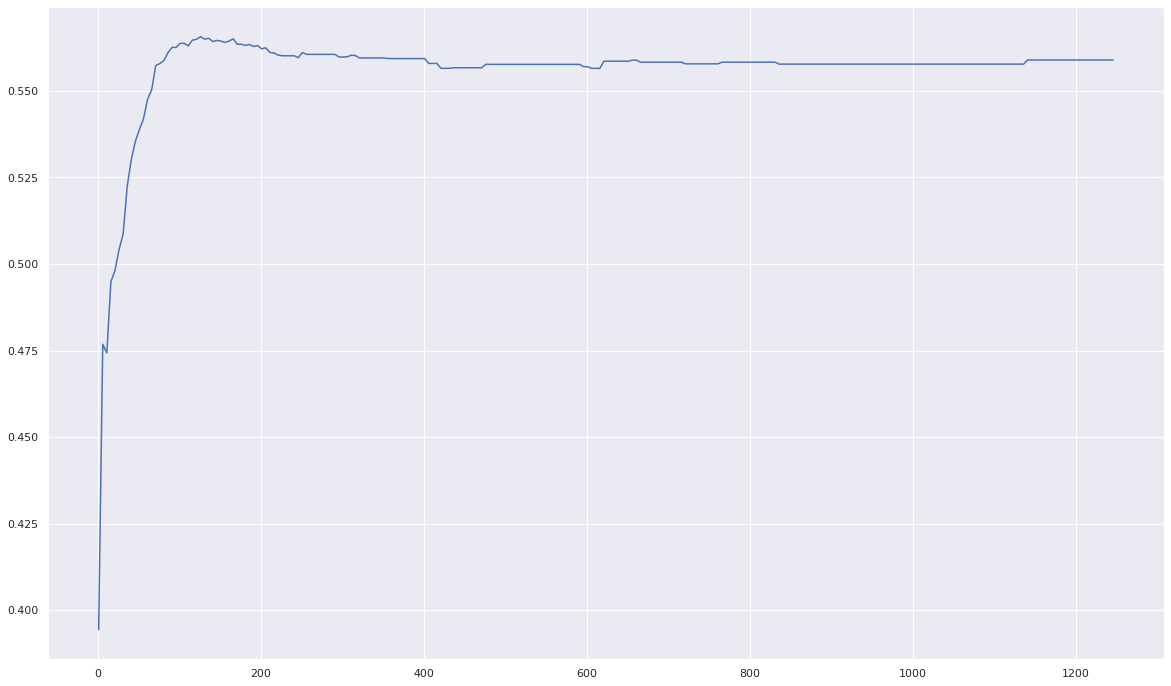

In [39]:
sns.set(rc={'figure.figsize':(20,12)})
sns.lineplot(data=f1_results_unigram_bigram_supervised)

In [40]:
# Getting the optimal number of features which will result in best mean cross validation F1-score from the dictionary

best_no_of_features= max(f1_results_unigram_bigram_supervised, key=f1_results_unigram_bigram_supervised.get)
best_no_of_features

126

In [41]:
# Extracting the optimal number of features into a dataframe for training

chi2_columns = chi2_df_sorted.columns[:best_no_of_features]
scaled_train_supervised_unigram_bigram_df_chi_square = train_supervised_unigram_bigram_chi_square_df[chi2_columns]
scaled_test_supervised_unigram_bigram_df_chi_square = test_supervised_unigram_bigram_chi_square_df[chi2_columns]

In [42]:
X_train = scaled_train_supervised_unigram_bigram_df_chi_square
X_test = scaled_test_supervised_unigram_bigram_df_chi_square

clf = AdaBoostClassifier(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 59.20%
Test Accuracy: 66.82%
Test F1 Score: 65.69%
Mean Cross Val Accuracy: 58.10%
Mean Cross Val F1 Score: 56.48%
Testing Matthew's coefficient: 0.342
